In [1]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
import collections
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) 

    def add(self, state, action, reward, next_state, done): 
        self.buffer.append((state, action, reward, next_state, done)) 

    def sample(self, batch_size): 
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done 

    def size(self): 
        return len(self.buffer)

In [3]:
class PolicyNet(nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim,action_bound):
        super().__init__()
        self.fc1=nn.Sequential(nn.Linear(state_dim,hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(hidden_dim,action_dim),nn.Tanh())
        self.action_bound=action_bound
    def forward(self,x):
        x=self.fc1(x)
        x=self.fc2(x)
        return x*self.action_bound
class ValueNet(nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super().__init__()
        self.fc1=nn.Sequential(nn.Linear(state_dim+action_dim,hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(hidden_dim,hidden_dim),nn.ReLU())
        self.fc_out=nn.Sequential(nn.Linear(hidden_dim,1))
    def forward(self,state,action):
        x=torch.cat([state,action],dim=-1)
        x=self.fc1(x)
        x=self.fc2(x)
        return self.fc_out(x)

In [24]:
class DDPG():
    def __init__(self,state_dim,hidden_dim,action_dim,action_bound,sigma,actor_lr,critic_lr,tau,gamma,
                device):
        self.actor=PolicyNet(state_dim,hidden_dim,action_dim,action_bound).to(device)
        self.critic=ValueNet(state_dim,hidden_dim,action_dim).to(device)
        self.target_actor=PolicyNet(state_dim,hidden_dim,action_dim,action_bound).to(device)
        self.target_critic=ValueNet(state_dim,hidden_dim,action_dim).to(device)
        
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())
        
        self.actor_optimizer=torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer=torch.optim.Adam(self.critic.parameters(),lr=critic_lr)
        
        self.gamma=gamma
        self.sigma=sigma
        self.tau=tau
        self.device=device
        self.action_dim=action_dim
    def take_action(self,state):
        state=torch.Tensor(state).unsqueeze(0).to(self.device)
        action=self.actor(state).item()
        action=action+self.sigma*np.random.rand(self.action_dim)
        return action
    def soft_update(self,net,target_net):
        for param_target,param in zip(target_net.parameters(),net.parameters()):
            param_target.data.copy_(param_target.data*(1-self.tau)+param.data*self.tau)
    def update(self,transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        
        next_q_values=self.target_critic(next_states,self.target_actor(next_states))
        q_targets=rewards+self.gamma*next_q_values*(1-dones)
        critic_loss=torch.mean(F.mse_loss(self.critic(states,actions),q_targets))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        actor_loss=-torch.mean(self.critic(states,self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        self.soft_update(self.actor,self.target_actor)
        self.soft_update(self.critic,self.target_critic)
    
    

In [26]:
actor_lr=1e-3
critic_lr=3e-3
epochs=200
hidden_dim=64
gamma=0.98
tau=0.005
buffer_size=10000
minimal_size=1000
batch_size=64
sigma=0.01
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

env_name = 'Pendulum-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)
from tqdm import tqdm
return_list=[]
for i in range(10):
    with tqdm(total=epochs//10,desc='iter %d'%i) as pbar:
        for epoch in range(epochs//10):
            rewards=0
            state,_=env.reset(seed=0)
            action=agent.take_action(state)
            done=False
            while not done:
                new_state,r,_,done,_=env.step(action)
                replay_buffer.add(state,action,r,new_state,done)
                new_action=agent.take_action(new_state)
                rewards+=r
                state=new_state
                action=new_action
                if replay_buffer.size()>minimal_size:
                    b_s,b_a,b_r,b_ns,b_d=replay_buffer.sample(batch_size)
                    tran_dict={
                        'states':b_s,
                        'actions':b_a,
                        'next_states':b_ns,
                        'rewards':b_r,
                        'dones':b_d,
                    }
                    agent.update(tran_dict)
                
            return_list.append(rewards)
            if (epoch+1) %10==0:
                pbar.set_postfix({
                    'epoch':'%d'%(epochs//10*i+epoch+1),
                    'return':'%.3f'%np.mean(return_list[-10:])
                })
            pbar.update(1)


iter 9: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it, epoch=200, return=-133.337]


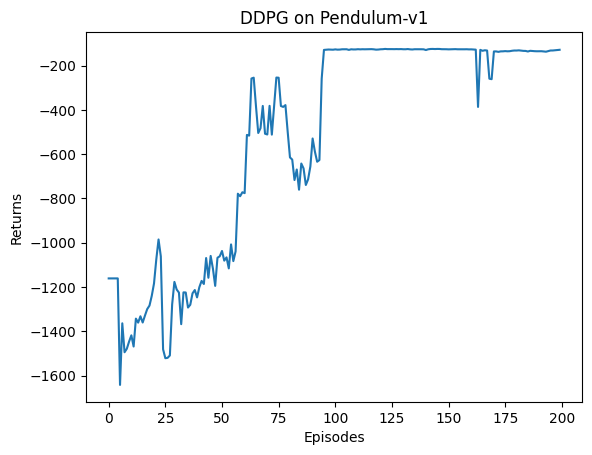

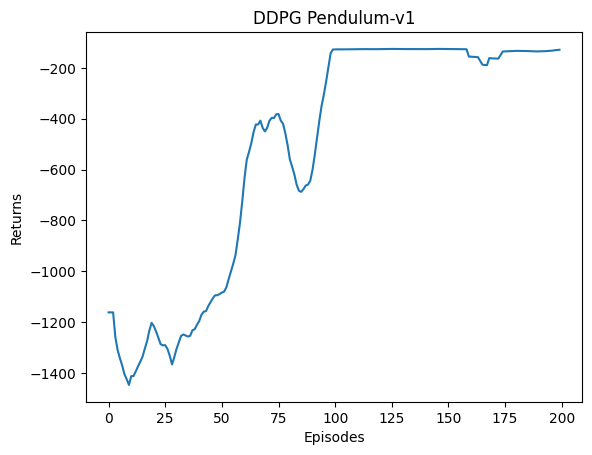

In [27]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))
mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG {}'.format(env_name))
plt.show()

In [19]:
class PolicyNet(nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim,action_bound):
        super().__init__()
        self.fc1=nn.Sequential(nn.Linear(state_dim,hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(hidden_dim,action_dim),nn.Tanh())
        self.action_bound=action_bound
    def forward(self,x):
        x=self.fc1(x)
        x=self.fc2(x)
        return x*self.action_bound
class DoubleValueNet(nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super().__init__()
        self.Qnet1=nn.Sequential(
            nn.Linear(state_dim+action_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,1),
        )
        self.Qnet2=nn.Sequential(
            nn.Linear(state_dim+action_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,1),
        )
    def forward(self,state,action):
        x=torch.cat([state,action],dim=-1)
        q1=self.Qnet1(x)
        q2=self.Qnet2(x)
        return q1,q2
    def Q1(self,state,action):
        x=torch.cat([state,action],dim=-1)
        return self.Qnet1(x)
    

In [33]:
import copy
class TD3():
    def __init__(
        self,
        state_dim, 
        hidden_dim,
        action_dim,
        action_bound,
        actor_lr,
        critic_lr,
        sigma,
        gamma,
        tau,
        policy_noise,
        noise_clip,
        policy_freq,
        device
    ):
        
        self.actor=PolicyNet(state_dim,hidden_dim,action_dim,action_bound).to(device)
        self.target_actor=copy.deepcopy(self.actor)
        self.actor_optimizer=torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        
        self.critic=DoubleValueNet(state_dim,hidden_dim,action_dim).to(device)
        self.target_critic=copy.deepcopy(self.critic)
        self.critic_optimizer=torch.optim.Adam(self.critic.parameters(),lr=critic_lr)
        
        self.action_dim=action_dim
        self.sigma=sigma
        self.gamma=gamma
        self.tau=tau
        self.policy_noise=policy_noise
        self.noise_clip=noise_clip
        self.policy_freq=policy_freq
        self.device=device
        self.action_bound=action_bound
        
        self.iters=0
    def take_action(self,state):
        state=torch.Tensor(state).unsqueeze(0).to(self.device)
        action=self.actor(state).item()
        noise=self.sigma*np.random.rand(self.action_dim)
        action=action+noise
        return action
    def soft_update(self,net,target_net):
        for param,target_param in zip(net.parameters(),target_net.parameters()):
            target_param.data.copy_(param.data*self.tau+target_param.data*(1-self.tau))
    def update(self,transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        
        
        with torch.no_grad():
            noise=(torch.randn_like(actions)*self.policy_noise).clamp(-self.noise_clip,self.noise_clip)
            next_actions=(self.target_actor(next_states)+noise).clamp(-self.action_bound,self.action_bound)
            target_Q1,target_Q2=self.target_critic(next_states,next_actions)
            target_Q=torch.min(target_Q1,target_Q2)
            target_Q=rewards+self.gamma*target_Q*(1-dones)
        
        current_Q1,current_Q2=self.critic(states,actions)
        critic_loss=F.mse_loss(current_Q1,target_Q)+F.mse_loss(current_Q2,target_Q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        self.iters+=1
        if self.iters%self.policy_freq==0:
            actor_loss=-self.critic.Q1(states,self.actor(states)).mean()
            
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            
            self.soft_update(self.actor,self.target_actor)
            self.soft_update(self.critic,self.target_critic)
            
            
    
        

In [40]:
import time
actor_lr=1e-3
critic_lr=3e-3
epochs=200
hidden_dim=64
gamma=0.98
tau=0.005
buffer_size=10000
minimal_size=1000
batch_size=64
sigma=0.01
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
policy_noise=0.2
noise_clip=0.5
policy_freq=2

env_name = 'Pendulum-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
agent = TD3(state_dim, hidden_dim, action_dim, action_bound,actor_lr,critic_lr,sigma, gamma, tau,policy_noise,
            noise_clip,policy_freq,device)
from tqdm import tqdm
return_list=[]
for i in range(10):
    with tqdm(total=epochs//10,desc='iter %d'%i) as pbar:
        for epoch in range(epochs//10):
            rewards=0
            state,_=env.reset(seed=0)
            action=agent.take_action(state)
            done=False
            while not done:
                new_state,r,_,done,_=env.step(action)
                replay_buffer.add(state,action,r,new_state,done)
                new_action=agent.take_action(new_state)
                rewards+=r
                state=new_state
                action=new_action
                if replay_buffer.size()>minimal_size:
                    b_s,b_a,b_r,b_ns,b_d=replay_buffer.sample(batch_size)
                    tran_dict={
                        'states':b_s,
                        'actions':b_a,
                        'next_states':b_ns,
                        'rewards':b_r,
                        'dones':b_d,
                    }
                    agent.update(tran_dict)
                
            return_list.append(rewards)
            if (epoch+1) %10==0:
                pbar.set_postfix({
                    'epoch':'%d'%(epochs//10*i+epoch+1),
                    'return':'%.3f'%np.mean(return_list[-10:])
                })
            time.sleep(0.1)
            pbar.update(1)


iter 9: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it, epoch=200, return=-226.216]


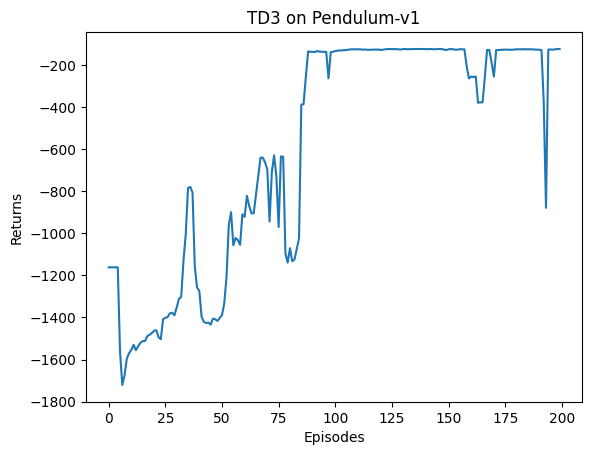

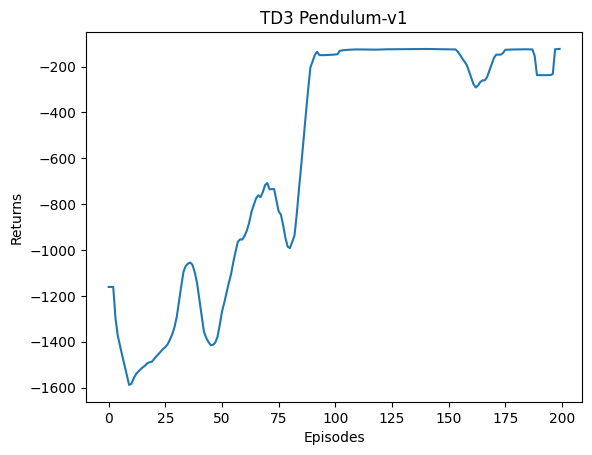

In [41]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TD3 on {}'.format(env_name))
plt.show()
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))
mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TD3 {}'.format(env_name))
plt.show()